<a href="https://colab.research.google.com/github/SinghNehal/Diabetes-Detection-using-Retinal-Images/blob/main/mini_project_Diabetic_retinopathy_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection Using Python
BY
* Nehal Singh (IIT2018119)
* PALAK MITTAL (IIT2018117)
* PUJA KUMARI (II2018191)
* PRABHA KUMARI (IIT2018195)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Nessesary libraries and modules from the local python environment

In [ ]:
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm

import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt
from google.colab.patches import cv2_imshow



# Pre-processing

## Loading Images and converting them to grey-Scale followed by adaptive histogram equilisation
### The final image matrix is stored in 1-D format to a new 2-D array

Original image is : 


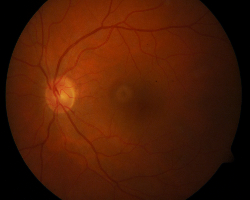

Original Grayscale image is : 


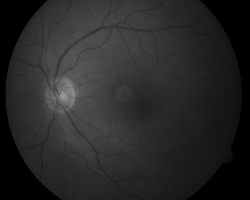

In [ ]:
immatrix=[]
im_unpre = []

for i in range(1,89):
    img_pt = "/content/drive/My Drive/MiniP/Datasets/diaretdb1_v_1_1/resources/images/ddb1_fundusimages/image"
    if i < 10:
        img_pt = img_pt + "00" + str(i) + ".png"
    else:
        img_pt = img_pt + "0" + str(i)+ ".png"
    img = cv2.imread(img_pt)
    #im_unpre.append(np.array(img).flatten())
    if i is 79:
     print("Original image is : ")
     imS = cv2.resize(img, (250, 200))  
     cv2_imshow(imS)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if i is 79:
     print("Original Grayscale image is : ")
     imS = cv2.resize(img_gray, (250, 200))  
     cv2_imshow(imS)
    equ = cv2.equalizeHist(img_gray) 
    immatrix.append(np.array(equ).flatten())
    #res = np.hstack((img_gray,equ))


In [ ]:
np.shape(np.array(equ).flatten())

(1728000,)

## Visualising a random image after the above steps the array contains 90 images

### The shape of the image is determined from np.shape(equ) and those values are 1152,1500

In [ ]:
np.shape(immatrix)
np.shape(equ)


(1152, 1500)

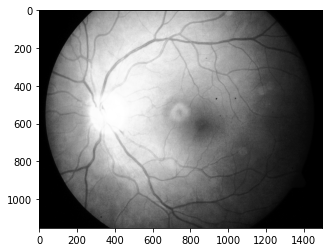

In [ ]:
plt.imshow(immatrix[78].reshape((1152,1500)),cmap='gray')
plt.show()

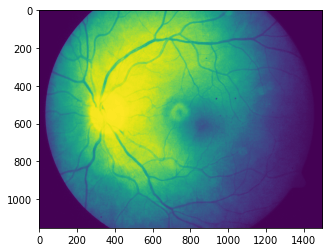

In [ ]:
plt.imshow(immatrix[78].reshape((1152,1500)))
plt.show()

## Performing Discrete-Wavelet transform on the 2-D array available

The Haar wavelet is a sequence of rescaled "square-shaped" functions which together form a wavelet family or basis. Wavelet analysis is similar to Fourier analysis in that it allows a target function over an interval to be represented in terms of an orthonormal basis. The Haar sequence is now recognised as the first known wavelet basis and extensively used as a teaching example.

In [ ]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((1152,1500))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())


## Visualising a random image 

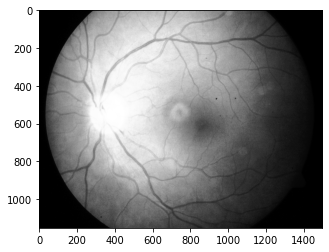

In [ ]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[78].reshape((1152,1500)),cmap='gray')
plt.show()

In [ ]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())


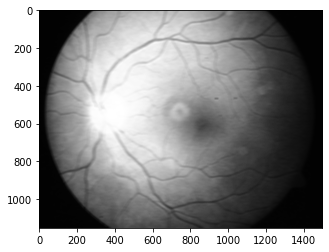

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss)
plt.imshow(imm_gauss[78].reshape((1152,1500)),cmap='gray')
plt.show()

In [ ]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


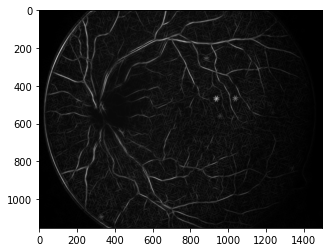

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[78].reshape((1152,1500)),cmap='gray')
plt.show()

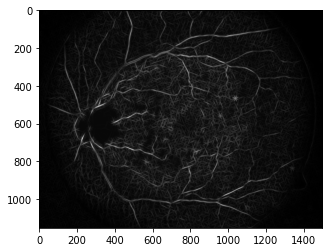

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[1].reshape((1152,1500)),cmap='gray')
plt.show()

In [ ]:
e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,3))
np.shape(e_)

(576000, 3)

## Performing K-means Clusttering with PP centers(non random) neighbours on the final image

In [ ]:
img = equ3
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

In [ ]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((1152,1500))
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())



In [ ]:
imm_kmean

[array([248, 246, 248, ..., 248, 246, 248], dtype=uint8),
 array([13,  9, 13, ..., 13,  9, 13], dtype=uint8),
 array([3, 1, 3, ..., 3, 1, 3], dtype=uint8),
 array([236, 234, 236, ..., 236, 234, 236], dtype=uint8),
 array([63, 60, 63, ..., 63, 60, 63], dtype=uint8),
 array([45, 42, 45, ..., 45, 42, 45], dtype=uint8),
 array([39, 37, 39, ..., 39, 37, 39], dtype=uint8),
 array([24, 21, 24, ..., 24, 21, 24], dtype=uint8),
 array([242, 239, 242, ..., 242, 239, 242], dtype=uint8),
 array([79, 76, 79, ..., 79, 76, 79], dtype=uint8),
 array([127, 122, 127, ..., 127, 122, 127], dtype=uint8),
 array([242, 241, 242, ..., 242, 241, 242], dtype=uint8),
 array([22, 18, 22, ..., 22, 18, 22], dtype=uint8),
 array([34, 31, 34, ..., 34, 31, 34], dtype=uint8),
 array([149, 144, 149, ..., 149, 144, 149], dtype=uint8),
 array([116, 109, 116, ..., 116, 109, 116], dtype=uint8),
 array([35, 33, 35, ..., 35, 33, 35], dtype=uint8),
 array([35, 32, 35, ..., 35, 32, 35], dtype=uint8),
 array([43, 39, 43, ..., 43,

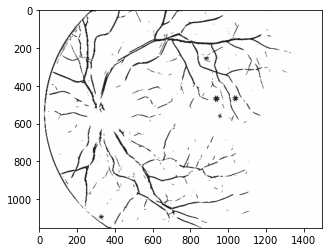

In [ ]:
# the array ranges from 0 - 89
np.shape(imm_kmean)
plt.imshow(imm_kmean[78].reshape((1152,1500)),cmap="gray")
plt.show()

# Model training

## USING SVM 

Importing SVc(same as SVM) from sklearn library

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
Y = np.ones(88)
Y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

These corresponding Images are marked as non-effected in the data-set

In [ ]:
Y[0]=Y[8]=Y[19]=Y[25]=Y[28]=Y[40]=Y[45]=Y[49]=Y[55]=Y[63]=Y[69]=Y[75]=Y[84]=0

In [ ]:
Y

array([0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1.])

SVM with Radial Basis Function (RBF)

Linear SVM classifies the data by putting a hyper plane between the two classes. In the case of rbf SVM the plane would be in infinite dimension

In [ ]:
k = [1,3,4,9,10,11,13,14,20,22,24,25,26,27,28,29,35,36,38,42,53,55,57,64,70,79,84,86]

In [ ]:
k = k-np.ones(len(k))

In [ ]:
k

array([ 0.,  2.,  3.,  8.,  9., 10., 12., 13., 19., 21., 23., 24., 25.,
       26., 27., 28., 34., 35., 37., 41., 52., 54., 56., 63., 69., 78.,
       83., 85.])

In [ ]:

k =[int(x) for x in k]


In [ ]:
k

[0,
 2,
 3,
 8,
 9,
 10,
 12,
 13,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 34,
 35,
 37,
 41,
 52,
 54,
 56,
 63,
 69,
 78,
 83,
 85]

In [ ]:
imm_train = []
y_train = []
for i in k:
    imm_train.append(imm_kmean[i])
    y_train.append(Y[i])
    

In [ ]:
y_train

[0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0]

In [ ]:
clf = SVC()

In [ ]:
clf.fit(imm_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(imm_kmean)

In [ ]:
accuracy_score(Y,y_pred)

0.8636363636363636

In [ ]:
print(classification_report(Y, y_pred, digits=6))

              precision    recall  f1-score   support

         0.0   1.000000  0.076923  0.142857        13
         1.0   0.862069  1.000000  0.925926        75

    accuracy                       0.863636        88
   macro avg   0.931034  0.538462  0.534392        88
weighted avg   0.882445  0.863636  0.810245        88



In [ ]:
# Print out confusion matrix
cmat = confusion_matrix(Y, y_pred)
print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

[[ 1 12]
 [ 0 75]]
TP - True Negative 1
FP - False Positive 12
FN - False Negative 0
TP - True Positive 75
Accuracy Rate: 0.8636363636363636
Misclassification Rate: 0.13636363636363635


### Accuracy for SVM is 86.36%

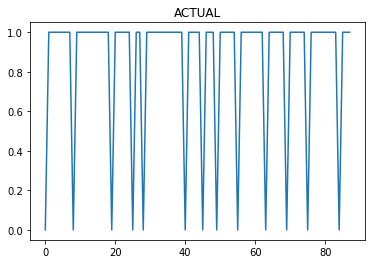

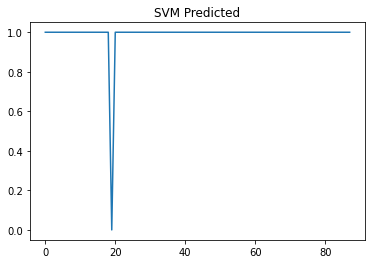

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Y)
plt.title("ACTUAL")
plt.show()
plt.plot(y_pred)

plt.title("SVM Predicted")
plt.show()

## USING KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(imm_train, y_train) 
y_pred2=neigh.predict(imm_kmean)
y_pred2


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [ ]:
accuracy_score(Y,y_pred2)

0.8522727272727273

In [ ]:
print(classification_report(Y, y_pred2, digits=6))

              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        13
         1.0   0.852273  1.000000  0.920245        75

    accuracy                       0.852273        88
   macro avg   0.426136  0.500000  0.460123        88
weighted avg   0.726369  0.852273  0.784300        88



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print out confusion matrix
cmat = confusion_matrix(Y, y_pred2)
print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

[[ 0 13]
 [ 0 75]]
TP - True Negative 0
FP - False Positive 13
FN - False Negative 0
TP - True Positive 75
Accuracy Rate: 0.8522727272727273
Misclassification Rate: 0.14772727272727273


### Accuracy for KNN is 85.22%

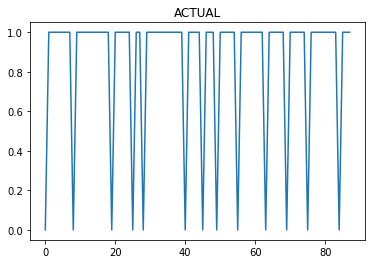

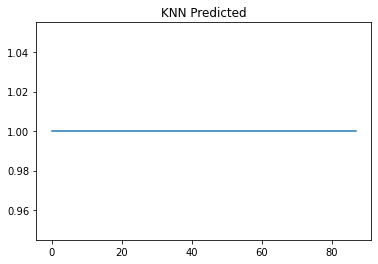

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Y)
plt.title("ACTUAL")
plt.show()
plt.plot(y_pred2)
plt.title("KNN Predicted")
plt.show()

#Predicting Diabetic or not using svm

Original image is : 


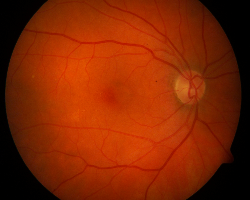

Grayscale image is : 


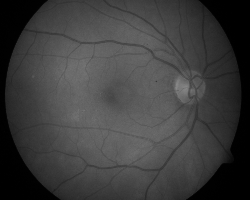

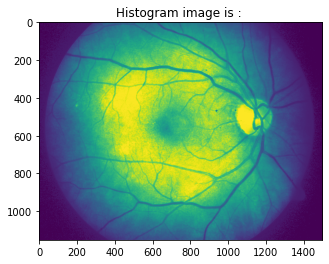

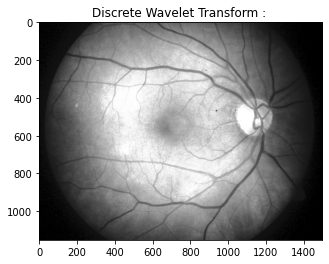

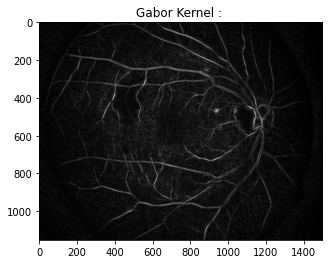

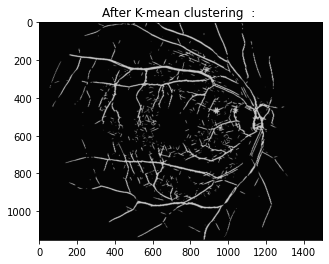

imm_kmean is : 


[array([62, 58, 62, ..., 62, 58, 62], dtype=uint8)]

In [ ]:
immatrix1=[]
img_pt1 = "check.png"
img1 = cv2.imread(img_pt1)
print("Original image is : ")
imS = cv2.resize(img1,(250, 200))  
cv2_imshow(imS)
img_gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print("Grayscale image is : ")
imS = cv2.resize(img_gray1, (250, 200))  
cv2_imshow(imS)
equ1 = cv2.equalizeHist(img_gray1) 
immatrix1.append(np.array(equ1).flatten())
plt.title("Histogram image is : ")
plt.imshow(immatrix1[0].reshape(1152,1500))
plt.show()
imm_dwt1 = []
for equ1 in immatrix1:
    equ1 = equ1.reshape((1152,1500))
    coeffs1 = pywt.dwt2(equ1, 'haar')
    equ21 = pywt.idwt2(coeffs1, 'haar')
    imm_dwt1.append(np.array(equ21).flatten())
plt.title("Discrete Wavelet Transform : ")
plt.imshow(imm_dwt1[0].reshape((1152,1500)),cmap='gray')
plt.show()

gf1 = gaussian_matched_filter_kernel(20, 5)
bank_gf1 = createMatchedFilterBank()



imm_gauss1 = []
for equ21 in imm_dwt1:
    equ21 = equ21.reshape((1152,1500))
    equ31 = applyFilters(equ21,bank_gf1)
    imm_gauss1.append(np.array(equ31).flatten())
bank_gf1 = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss21 = []
for equ21 in imm_dwt1:
    equ21 = equ21.reshape((1152,1500))
    equ31 = applyFilters(equ21,bank_gf1)
    imm_gauss21.append(np.array(equ31).flatten())

plt.title("Gabor Kernel : ")
np.shape(imm_gauss21)
plt.imshow(imm_gauss21[0].reshape((1152,1500)),cmap='gray')
plt.show()

e_ = equ31
np.shape(e_)
e_=e_.reshape((-1,3))
np.shape(e_)
img = equ31
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
imm_kmean = []
for equ3 in imm_gauss21:
    img = equ3.reshape((1152,1500))
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())

np.shape(imm_kmean)
plt.title("After K-mean clustering  : ")
plt.imshow(imm_kmean[0].reshape((1152,1500)),cmap="gray")
plt.show()
print("imm_kmean is : ")
imm_kmean


In [ ]:
y_pred = clf.predict(imm_kmean)
y_pred

array([1.])

In [ ]:
if y_pred[0] is '0.':
  print("Non- Diabetic")
else:
  print("Diabetic")

Diabetic
